In [1]:
pip install pandas numpy opencv-python matplotlib scikit-image scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder


In [3]:
# Funzione per estrarre media e deviazione standard dei colori
def extract_color_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR a RGB
    mean_color = np.mean(image, axis=(0, 1))  # Media per ogni canale
    std_color = np.std(image, axis=(0, 1))  # Deviazione standard per ogni canale
    return mean_color, std_color

# Funzione per estrarre caratteristiche di texture
def extract_texture_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    entropy = graycoprops(glcm, 'entropy')[0, 0]
    return contrast, entropy


In [4]:
# Carica i CSV
train_small_df = pd.read_csv('dataset/train_small.csv', header=None, names=["Image", "Label"])
train_unlabeled_df = pd.read_csv('dataset/train_unlabeled.csv', header=None, names=["Image", "Label"])
val_info_df = pd.read_csv('dataset/val_info.csv', header=None, names=["Image", "Label"])

# Mostra una parte dei dati per un controllo iniziale
train_small_df.head(), train_unlabeled_df.head(), val_info_df.head()

(              Image  Label
 0  train_059371.jpg      0
 1  train_059389.jpg      0
 2  train_059425.jpg      0
 3  train_059445.jpg      0
 4  train_059516.jpg      0,
               Image  Label
 0  train_059329.jpg     -1
 1  train_059330.jpg     -1
 2  train_059331.jpg     -1
 3  train_059332.jpg     -1
 4  train_059333.jpg     -1,
             Image  Label
 0  val_010323.jpg    247
 1  val_010324.jpg    234
 2  val_010325.jpg    222
 3  val_010326.jpg    240
 4  val_010327.jpg    218)

In [17]:
# Funzione per elaborare le immagini
def process_images(csv_df, image_folder):
    features = []
    for idx, row in csv_df.iterrows():
        image_path = os.path.join(image_folder, row["Image"])
        label = row["Label"]
        
        # Estrai le feature di colore
        mean_color, std_color = extract_color_features(image_path)
        
        # Estrai le feature di texture
        contrast, entropy = extract_texture_features(image_path)
        
        # Aggiungi le feature in un array
        features.append([mean_color[0], mean_color[1], mean_color[2],
                         std_color[0], std_color[1], std_color[2],
                         contrast, entropy, label])
    
    return pd.DataFrame(features, columns=["mean_r", "mean_g", "mean_b", 
                                           "std_r", "std_g", "std_b", 
                                           "contrast", "entropy", "label"])


In [18]:
# Elaborazione delle immagini di train e validation
train_features = process_images(train_small_df, 'dataset/train_set')
val_features = process_images(val_info_df, 'dataset/val_set')

# Mostra un'anteprima delle prime righe delle feature estratte
train_features.head(), val_features.head()


(       mean_r      mean_g      mean_b      std_r      std_g      std_b  \
 0  127.553795  143.740503  142.160664  42.895567  36.568607  42.917304   
 1  237.550797  206.504166  178.623505  25.212643  60.420738  97.198457   
 2  172.565536  181.001556  168.053314  43.822010  39.280200  43.950498   
 3  222.339798  221.968693  212.522116  45.480424  40.751339  55.534220   
 4  194.126841  192.170351  184.173992  34.799278  35.385342  39.688888   
 
      contrast   entropy  label  
 0  202.282023  8.702568      0  
 1   66.656250  5.982586      0  
 2  121.823192  7.871894      0  
 3  147.291141  5.920534      0  
 4  146.556432  7.426955      0  ,
        mean_r      mean_g      mean_b      std_r      std_g      std_b  \
 0  106.192394  103.540649  127.679882  92.930450  86.701891  70.900267   
 1  154.974707  144.764862  130.411063  81.598575  76.484336  68.655263   
 2  177.370651  126.256493   92.420197  44.922227  65.933650  72.791013   
 3  149.803233   98.476986   73.493482  61.

In [19]:
# Analisi statistica delle feature per classe
train_stats = train_features.groupby('label').mean()
val_stats = val_features.groupby('label').mean()

# Visualizza le statistiche
train_stats, val_stats


(           mean_r      mean_g      mean_b      std_r      std_g      std_b  \
 label                                                                        
 0      183.094834  158.565887  144.064549  46.776447  53.453247  56.108030   
 1      161.646304  142.546953  128.124791  52.892564  60.136159  66.777627   
 2      186.229468  160.721032  140.433477  48.108871  58.595701  68.955837   
 3      147.976132  128.704837  109.293406  62.237762  65.996889  72.156210   
 4      170.123489  137.877722  101.494035  55.390090  61.445114  71.058808   
 ...           ...         ...         ...        ...        ...        ...   
 246    174.727588  157.147858  127.984951  52.167189  54.950639  67.078351   
 247    171.719713  147.696658  122.990495  50.618659  54.774001  64.295673   
 248    163.699195  137.538339  101.036891  58.430084  64.198373  73.513692   
 249    158.398623  115.416394   84.452871  60.565404  65.816366  69.480763   
 250    170.327744  131.220998  106.770691  52.69131

In [20]:
# Normalizzazione delle feature con Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

# Selezioniamo le feature numeriche da normalizzare (escludendo la colonna 'label')
features_columns = train_features.columns[:-1]

# Creiamo un oggetto MinMaxScaler
scaler = MinMaxScaler()

# Normalizziamo le feature di train e validation
train_features_scaled = train_features.copy()
val_features_scaled = val_features.copy()

# Applichiamo la normalizzazione sulle feature
train_features_scaled[features_columns] = scaler.fit_transform(train_features[features_columns])
val_features_scaled[features_columns] = scaler.transform(val_features[features_columns])

# Visualizza le prime righe delle feature normalizzate
train_features_scaled.head(), val_features_scaled.head()


(     mean_r    mean_g    mean_b     std_r     std_g     std_b  contrast  \
 0  0.495263  0.533712  0.546487  0.347896  0.231000  0.315217  0.043204   
 1  0.934644  0.803666  0.696830  0.191331  0.460746  0.827835  0.013816   
 2  0.675062  0.693976  0.653247  0.356099  0.257118  0.324974  0.025770   
 3  0.873884  0.870181  0.836601  0.370782  0.271289  0.434368  0.031288   
 4  0.761188  0.742014  0.719716  0.276211  0.219603  0.284728  0.031129   
 
     entropy  label  
 0  0.842098      0  
 1  0.554508      0  
 2  0.754269      0  
 3  0.547947      0  
 4  0.707224      0  ,
      mean_r    mean_g    mean_b     std_r     std_g     std_b  contrast  \
 0  0.409935  0.360808  0.486779  0.790905  0.713889  0.579481  0.059174   
 1  0.604795  0.538118  0.498041  0.690573  0.615472  0.558280  0.360608   
 2  0.694256  0.458511  0.341397  0.365840  0.513847  0.597337  0.036289   
 3  0.584138  0.339028  0.263358  0.508435  0.633990  0.686385  0.046574   
 4  0.751737  0.737249  0.723

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Selezioniamo le feature numeriche da normalizzare (escludendo la colonna 'label')
features_columns = train_features.columns[:-1]

# Le label si trovano nell'ultima colonna
train_labels = train_features.iloc[:, -1]
val_labels = val_features.iloc[:, -1]

# Crea il classificatore KNN (puoi scegliere un valore di k)
k = 500  # esempio di valore di k
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Allena il modello sui dati normalizzati di training, escludendo la colonna delle label
knn_classifier.fit(train_features_scaled[features_columns], train_labels)

# Esegui le predizioni sul set di validazione
val_predictions = knn_classifier.predict(val_features_scaled[features_columns])

# Calcola l'accuratezza del modello sul set di validazione
accuracy = accuracy_score(val_labels, val_predictions)

print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")


L'accuratezza del modello KNN è: 1.21%


Probabilmente cattivi risultati perchè sto facendo la media, quindi i cibi (comprensivi di sfondo) tendono al grigio (confermnato dai valori precedenti). Quindi come prossimo step per quanto rigurarda il colore possiamo provare a utilizzare gli istogrammi che mostrano la distribuzione del colore.

In [6]:
def extract_histogram_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR a RGB
    hist_r = cv2.calcHist([image], [0], None, [64], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [64], [0, 256]).flatten()
    hist_b = cv2.calcHist([image], [2], None, [64], [0, 256]).flatten()
    return hist_r, hist_g, hist_b

In [8]:
# Funzione per elaborare le immagini
def process_images(csv_df, image_folder):
    features = []
    for idx, row in csv_df.iterrows():
        image_path = os.path.join(image_folder, row["Image"])
        label = row["Label"]
        
        # Estrai l'istogramma dei colori
        hist_r, hist_g, hist_b = extract_histogram_features(image_path)
        
        # Estrai le feature di texture
        contrast, entropy = extract_texture_features(image_path)
        
        # Aggiungi le feature in un array
        features.append([*hist_r, *hist_g, *hist_b, contrast, entropy, label])
    
    return pd.DataFrame(features, columns=["hist_r"]*64 + ["hist_g"]*64 + ["hist_b"]*64 + ["contrast", "entropy", "label"])


In [9]:
# Elaborazione delle immagini di train e validation
train_features = process_images(train_small_df, 'dataset/train_set')
val_features = process_images(val_info_df, 'dataset/val_set')

# Mostra un'anteprima delle prime righe delle feature estratte
train_features.head(), val_features.head()


(   hist_r  hist_r  hist_r  hist_r  hist_r  hist_r  hist_r  hist_r  hist_r  \
 0     0.0     0.0     4.0    10.0    25.0    51.0   105.0   150.0   211.0   
 1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2   129.0    52.0    66.0    60.0    65.0    66.0    78.0    94.0    94.0   
 3     0.0     0.0     0.0     1.0     1.0     4.0    11.0    13.0    12.0   
 4     0.0     4.0     5.0    11.0    19.0    39.0    60.0    93.0    97.0   
 
    hist_r  ...  hist_b  hist_b  hist_b  hist_b   hist_b   hist_b   hist_b  \
 0   304.0  ...   139.0   111.0    84.0    60.0     39.0     11.0     13.0   
 1     0.0  ...  1412.0  1071.0   842.0  1212.0   1836.0   4390.0  23309.0   
 2   164.0  ...   754.0   509.0   391.0   149.0     42.0     28.0     21.0   
 3    23.0  ...  1067.0  1304.0  1769.0  4633.0  14135.0  25864.0   7214.0   
 4   116.0  ...  1608.0  1074.0   890.0   736.0    429.0    188.0     30.0   
 
      contrast   entropy  label  
 0  202.282023  8.702568  

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Selezioniamo le feature numeriche da normalizzare (escludendo la colonna 'label')
features_columns = train_features.columns[:-1]

# Le label si trovano nell'ultima colonna
train_labels = train_features.iloc[:, -1]
val_labels = val_features.iloc[:, -1]

# Crea il classificatore KNN (puoi scegliere un valore di k)
k = 500  
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Allena il modello sui dati normalizzati di training, escludendo la colonna delle label
knn_classifier.fit(train_features[features_columns], train_labels)

# Esegui le predizioni sul set di validazione
val_predictions = knn_classifier.predict(val_features[features_columns])

# Calcola l'accuratezza del modello sul set di validazione
accuracy = accuracy_score(val_labels, val_predictions)

print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")

L'accuratezza del modello KNN è: 1.11%


In [1]:
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os

# Caricamento dei dataset
train_small_df = pd.read_csv('dataset/train_small.csv', header=None, names=["Image", "Label"])
val_info_df = pd.read_csv('dataset/val_info.csv', header=None, names=["Image", "Label"])

# Aggiungi il percorso della cartella delle immagini
train_images_folder = 'dataset/train_set/'  # Cambia questo con il percorso corretto
val_images_folder = 'dataset/val_set/'  # Cambia questo con il percorso corretto

# Funzione per caricare e preprocessare le immagini
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Carica immagine a colori
    
    # Ottieni le dimensioni originali dell'immagine
    height, width, _ = img.shape
    
    # Calcola le coordinate per il taglio del quadrato centrale 256x256
    start_x = (width - 256) // 2
    start_y = (height - 256) // 2
    
    # Taglia l'immagine per ottenere un quadrato centrale 256x256
    img_cropped = img[start_y:start_y+256, start_x:start_x+256]
    return img_cropped

# Funzione per calcolare l'istogramma dei colori
def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()  # Appiattire l'istogramma in un vettore
    hist = hist / np.linalg.norm(hist)  # Normalizzare l'istogramma
    return hist

# Funzione per estrarre le caratteristiche HOG
def extract_hog(img):
    gray = rgb2gray(img)  # Converti in scala di grigi
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Funzione per estrarre le caratteristiche LBP
def extract_lbp(img):
    gray = rgb2gray(img)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalizza l'istogramma
    return lbp_hist

# Funzione per estrarre le caratteristiche SIFT
def extract_sift(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return descriptors.flatten()  # Appiattisci i descrittori
    else:
        return np.zeros(128)  # Se non ci sono descrittori, restituisci un vettore zero

# Estrazione delle caratteristiche per il training set
X_train = []  # Caratteristiche
y_train = []  # Etichette

X_test = []  # Caratteristiche
y_test = []  # Etichette

for idx, row in train_small_df.iterrows():
    img_name = row['Image']  # Nome immagine
    label = row['Label']  # Etichetta
    
    # Creare il percorso completo dell'immagine
    img_path = os.path.join(train_images_folder, img_name)
    
    img = preprocess_image(img_path)  # Carica e preprocessa l'immagine
    
    # Estrazione delle caratteristiche
    hog_features = extract_hog(img)
    lbp_features = extract_lbp(img)
    hist_features = color_histogram(img)
    # sift_features = extract_sift(img)
    
    # Combina tutte le caratteristiche in un singolo vettore
    # features = np.concatenate([hog_features, lbp_features, hist_features, sift_features])
    features = np.concatenate([hog_features, lbp_features, hist_features])
    
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

for idx, row in val_info_df.iterrows():
    img_name = row['Image']  # Nome immagine
    label = row['Label']  # Etichetta
    
    # Creare il percorso completo dell'immagine
    img_path = os.path.join(val_images_folder, img_name)
    
    img = preprocess_image(img_path)  # Carica e preprocessa l'immagine
    
    # Estrazione delle caratteristiche
    hog_features = extract_hog(img)
    lbp_features = extract_lbp(img)
    hist_features = color_histogram(img)
    # sift_features = extract_sift(img)
    
    # Combina tutte le caratteristiche in un singolo vettore
    # features = np.concatenate([hog_features, lbp_features, hist_features, sift_features])
    features = np.concatenate([hog_features, lbp_features, hist_features])
    
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)


# Creazione e addestramento del classificatore KNN
knn = KNeighborsClassifier(n_neighbors=3)  # Puoi cambiare il numero di vicini
knn.fit(X_train, y_train)

# Predizione sui dati di test
y_pred = knn.predict(X_test)

# Valutazione del modello sui dati di test
print("Test Set Classification Report:")
accuracy = accuracy_score(y_test, y_pred)
print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")
# print(classification_report(y_test, y_pred))


c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


KeyboardInterrupt: 

In [10]:
# Grid Search per trovare il miglior valore di k
k_values = [5, 10, 20, 50, 100, 200, 500]

for k in k_values:
    # Creazione e addestramento del classificatore KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predizione sui dati di test
    y_pred = knn.predict(X_test)

    # Valutazione del modello sui dati di test
    accuracy = accuracy_score(y_test, y_pred)
    print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")

Test Set Classification Report (k=5):
              precision    recall  f1-score   support

           0       0.03      0.05      0.04        55
           1       0.02      0.05      0.03        61
           2       0.00      0.00      0.00        53
           3       0.01      0.04      0.02        51
           4       0.01      0.02      0.01        41
           5       0.01      0.02      0.01        52
           6       0.01      0.05      0.01        57
           7       0.01      0.02      0.01        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.06      0.04      0.05        48
          11       0.00      0.00      0.00        47
          12       0.01      0.16      0.02        45
          13       0.03      0.03      0.03        61
          14       0.00      0.00      0.00        46
          15       0.01      0.02      0.01        57
          16       0.01      0.08      0.01

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=10):
              precision    recall  f1-score   support

           0       0.02      0.05      0.03        55
           1       0.02      0.08      0.03        61
           2       0.00      0.00      0.00        53
           3       0.01      0.06      0.02        51
           4       0.01      0.05      0.02        41
           5       0.00      0.02      0.01        52
           6       0.01      0.05      0.01        57
           7       0.00      0.00      0.00        54
           8       0.01      0.02      0.01        49
           9       0.00      0.00      0.00        46
          10       0.02      0.02      0.02        48
          11       0.01      0.02      0.01        47
          12       0.01      0.16      0.02        45
          13       0.02      0.03      0.03        61
          14       0.00      0.02      0.01        46
          15       0.01      0.02      0.01        57
          16       0.01      0.10      0.0

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=20):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.02      0.08      0.03        61
           2       0.00      0.00      0.00        53
           3       0.00      0.02      0.01        51
           4       0.01      0.02      0.01        41
           5       0.00      0.00      0.00        52
           6       0.00      0.04      0.01        57
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.03      0.02      0.02        48
          11       0.01      0.02      0.02        47
          12       0.01      0.16      0.02        45
          13       0.05      0.03      0.04        61
          14       0.00      0.00      0.00        46
          15       0.03      0.04      0.03        57
          16       0.01      0.12      0.0

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=50):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
           2       0.25      0.02      0.04        53
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        41
           5       0.02      0.04      0.03        52
           6       0.00      0.00      0.00        57
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        47
          12       0.00      0.09      0.01        45
          13       0.12      0.03      0.05        61
          14       0.00      0.00      0.00        46
          15       0.00      0.00      0.00        57
          16       0.01      0.18      0.0

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=100):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        52
           6       0.00      0.02      0.01        57
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        47
          12       0.01      0.09      0.01        45
          13       0.00      0.00      0.00        61
          14       0.00      0.00      0.00        46
          15       0.00      0.00      0.00        57
          16       0.01      0.08      0.

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=200):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        52
           6       0.02      0.09      0.03        57
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        47
          12       0.00      0.04      0.01        45
          13       0.11      0.02      0.03        61
          14       0.00      0.00      0.00        46
          15       0.00      0.00      0.00        57
          16       0.01      0.08      0.

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Test Set Classification Report (k=500):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        52
           6       0.00      0.02      0.01        57
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        47
          12       0.00      0.02      0.00        45
          13       0.00      0.00      0.00        61
          14       0.00      0.00      0.00        46
          15       0.04      0.02      0.02        57
          16       0.01      0.06      0.

c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [2]:
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os

# Caricamento dei dataset
train_small_df = pd.read_csv('dataset/train_small.csv', header=None, names=["Image", "Label"])
val_info_df = pd.read_csv('dataset/val_info.csv', header=None, names=["Image", "Label"])

# Aggiungi il percorso della cartella delle immagini
train_images_folder = 'dataset/train_set/'  # Cambia questo con il percorso corretto
val_images_folder = 'dataset/val_set/'  # Cambia questo con il percorso corretto

# Funzione per caricare e preprocessare le immagini
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Carica immagine a colori
    
    # Ottieni le dimensioni originali dell'immagine
    height, width, _ = img.shape
    
    # Calcola le coordinate per il taglio del quadrato centrale 256x256
    start_x = (width - 256) // 2
    start_y = (height - 256) // 2
    
    # Taglia l'immagine per ottenere un quadrato centrale 256x256
    img_cropped = img[start_y:start_y+256, start_x:start_x+256]
    return img_cropped

# Funzione per calcolare l'istogramma dei colori
def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()  # Appiattire l'istogramma in un vettore
    hist = hist / np.linalg.norm(hist)  # Normalizzare l'istogramma
    return hist

# Funzione per estrarre le caratteristiche HOG
def extract_hog(img):
    gray = rgb2gray(img)  # Converti in scala di grigi
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Funzione per estrarre le caratteristiche LBP
def extract_lbp(img):
    gray = rgb2gray(img)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalizza l'istogramma
    return lbp_hist

# Funzione per estrarre le caratteristiche SIFT
def extract_sift(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return descriptors.flatten()  # Appiattisci i descrittori
    else:
        return np.zeros(128)  # Se non ci sono descrittori, restituisci un vettore zero

# Estrazione delle caratteristiche per il training set
X_train = []  # Caratteristiche
y_train = []  # Etichette

X_test = []  # Caratteristiche
y_test = []  # Etichette

for idx, row in train_small_df.iterrows():
    img_name = row['Image']  # Nome immagine
    label = row['Label']  # Etichetta
    
    # Creare il percorso completo dell'immagine
    img_path = os.path.join(train_images_folder, img_name)
    
    img = preprocess_image(img_path)  # Carica e preprocessa l'immagine
    
    # Estrazione delle caratteristiche
    hog_features = extract_hog(img)
    
    # Combina tutte le caratteristiche in un singolo vettore
    # features = np.concatenate([hog_features, lbp_features, hist_features, sift_features])
    features = np.concatenate([hog_features])
    
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

for idx, row in val_info_df.iterrows():
    img_name = row['Image']  # Nome immagine
    label = row['Label']  # Etichetta
    
    # Creare il percorso completo dell'immagine
    img_path = os.path.join(val_images_folder, img_name)
    
    img = preprocess_image(img_path)  # Carica e preprocessa l'immagine
    
    # Estrazione delle caratteristiche
    hog_features = extract_hog(img)
    
    # Combina tutte le caratteristiche in un singolo vettore
    # features = np.concatenate([hog_features, lbp_features, hist_features, sift_features])
    features = np.concatenate([hog_features])
    
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)


# Creazione e addestramento del classificatore KNN
knn = KNeighborsClassifier(n_neighbors=3)  # Puoi cambiare il numero di vicini
knn.fit(X_train, y_train)

# Predizione sui dati di test
y_pred = knn.predict(X_test)

# Valutazione del modello sui dati di test
print("Test Set Classification Report:")
accuracy = accuracy_score(y_test, y_pred)
print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")
# print(classification_report(y_test, y_pred))


c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sguid\Uni\visual\project\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Test Set Classification Report:


NameError: name 'accuracy_score' is not defined

In [4]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=500)  # Puoi cambiare il numero di vicini
knn.fit(X_train, y_train)

# Predizione sui dati di test
y_pred = knn.predict(X_test)

# Valutazione del modello sui dati di test
print("Test Set Classification Report:")
accuracy = accuracy_score(y_test, y_pred)
print(f"L'accuratezza del modello KNN è: {accuracy * 100:.2f}%")

Test Set Classification Report:
L'accuratezza del modello KNN è: 0.53%


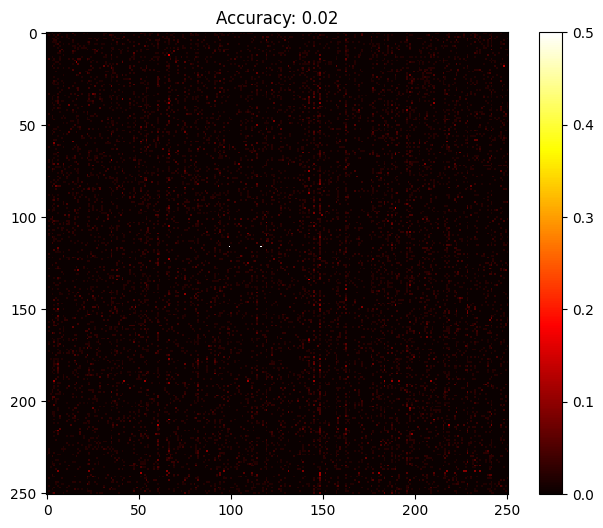

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import cv2
from scipy.spatial.distance import cdist

# Carica i CSV
train_small_df = pd.read_csv('dataset/train_small.csv', header=None, names=["Image", "Label"]) 
val_info_df = pd.read_csv('dataset/val_info.csv', header=None, names=["Image", "Label"])

# Creazione griglia
pointPositions = []
featStep = 10
imsize = 256
for ii in range(featStep, imsize - featStep, featStep):
    for jj in range(featStep, imsize - featStep, featStep):
        pointPositions.append([ii, jj])

# Estrazione features sul training
Nim4training = 70  # training images
features = []
labels = []

for idx, row in train_small_df.iterrows():
    image_path = f"./dataset/train_set/{row['Image']}"
    im = cv2.imread(image_path)
    im = cv2.resize(im, (imsize, imsize))
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Extract SURF features
    surf = cv2.SIFT_create()
    kp, des = surf.detectAndCompute(im_gray, None)
    
    features.append(des)
    labels.extend([row['Label']] * len(des))

# Creazione vocabolario con KMeans
K = 150  # TBD
features_flat = np.vstack(features)
kmeans = KMeans(n_clusters=K, max_iter=1000)
kmeans.fit(features_flat)

# Creazione istogrammi di training (BOW)
BOW_tr = []
labels_tr = []

for idx, row in train_small_df.iterrows():
    image_path = f"./dataset/train_set/{row['Image']}"
    im = cv2.imread(image_path)
    im = cv2.resize(im, (imsize, imsize))
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Extract features for the current image
    kp, des = surf.detectAndCompute(im_gray, None)
    
    # Find the closest clusters for the features
    D = cdist(des, kmeans.cluster_centers_)
    words = np.argmin(D, axis=1)
    
    # Compute histogram of words
    H, _ = np.histogram(words, bins=np.arange(K+1))
    H = H / np.sum(H)
    
    BOW_tr.append(H)
    labels_tr.append(row['Label'])

# Creazione istogrammi test
BOW_te = []
labels_te = []

for idx, row in val_info_df.iterrows():
    image_path = f"./dataset/val_set/{row['Image']}"
    im = cv2.imread(image_path)
    im = cv2.resize(im, (imsize, imsize))
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Extract features for the current image
    kp, des = surf.detectAndCompute(im_gray, None)
    
    # Find the closest clusters for the features
    D = cdist(des, kmeans.cluster_centers_)
    words = np.argmin(D, axis=1)
    
    # Compute histogram of words
    H, _ = np.histogram(words, bins=np.arange(K+1))
    H = H / np.sum(H)
    
    BOW_te.append(H)
    labels_te.append(row['Label'])

# Classificazione del test set
predicted_class = []

for te_hist in BOW_te:
    D = cdist([te_hist], BOW_tr)
    closest = np.argmin(D, axis=1)
    predicted_class.append(labels_tr[closest[0]])

# Misurazione performance
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_te, predicted_class)
CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Calculate accuracy
accuracy = np.mean(np.diag(CM))

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(CM, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Accuracy: {accuracy:.2f}')
plt.show()
